In [10]:
import pandas as pd
import numpy as np
from pathlib import Path

# === Đường dẫn file ===
DATA_PATH = "data_clean (1).xlsx"   # đổi nếu bạn để ở nơi khác

# 1.1 Load
df = pd.read_excel(Path(DATA_PATH), sheet_name="ticket")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])

# 1.2 Gộp theo ngày (vé)
daily = (df.groupby("date", as_index=False)
           .agg(tickets=("Số lượng vé", "sum"))
           .sort_values("date"))

# (Tuỳ chọn) Gộp theo ngày (doanh thu) – loại trùng order để tránh đếm lặp
daily_rev = (df.drop_duplicates(subset=["date","orderid"])
               .groupby("date", as_index=False)
               .agg(revenue=("total", "sum"))
               .sort_values("date"))
daily = daily.merge(daily_rev, on="date", how="left")

# 1.3 (để dành cho mô hình khác) – biến lịch
daily["dow"] = daily["date"].dt.dayofweek                     # Mon=0..Sun=6
daily["week_of_month"] = ((daily["date"].dt.day-1)//7 + 1).astype(int)
daily["is_weekend"] = daily["dow"].isin([5,6]).astype(int)

# 1.4 Lọc THÁNG 5 & reindex đủ ngày (điền 0 nếu thiếu)
month_may = daily[daily["date"].dt.month == 5].copy()
if not month_may.empty:
    full_idx = pd.date_range(month_may["date"].min(), month_may["date"].max(), freq="D")
    month_may = (month_may.set_index("date")
                           .reindex(full_idx)
                           .fillna({"tickets":0, "revenue":0})
                           .reset_index()
                           .rename(columns={"index":"date"}))

# Chuẩn hoá sau reindex
month_may["date"] = pd.to_datetime(month_may["date"]).dt.normalize()
month_may["tickets"] = month_may["tickets"].astype(float)
if "revenue" in month_may.columns:
    month_may["revenue"] = month_may["revenue"].fillna(0).astype(float)

# Tính lại biến lịch (vì vừa reindex)
month_may["dow"] = month_may["date"].dt.dayofweek
month_may["week_of_month"] = ((month_may["date"].dt.day-1)//7 + 1).astype(int)
month_may["is_weekend"] = month_may["dow"].isin([5,6]).astype(int)

print("Số ngày train (tháng 5):", len(month_may))
print(month_may.head())


Số ngày train (tháng 5): 31
        date      tickets     revenue  dow  week_of_month  is_weekend
0 2019-05-01  2938.000000  64630000.0    2              1           0
1 2019-05-02  3534.500000  59985000.0    3              1           0
2 2019-05-03   336.000000   7425000.0    4              1           0
3 2019-05-04     0.000000         0.0    5              1           1
4 2019-05-05  5768.333333  89720000.0    6              1           1


In [11]:
# BƯỚC 2 – Tạo index cho THÁNG 6 từ dữ liệu THÁNG 5
assert not month_may.empty, "month_may rỗng. Kiểm tra lại Bước 1."

last_day_may = month_may["date"].max().normalize()
start_june = (last_day_may + pd.Timedelta(days=1)).normalize()
end_june   = start_june + pd.offsets.MonthEnd(0)     # ngày cuối T6
H = int((end_june - start_june).days + 1)            # số ngày cần dự báo

# Tạo dải ngày của tháng 6
forecast_index = pd.date_range(start=start_june, end=end_june, freq="D")

print("Dự báo từ:", start_june.date(), "đến:", end_june.date(), "=>", H, "ngày")
print("5 ngày đầu:", [d.date() for d in forecast_index[:5]])
print("5 ngày cuối:", [d.date() for d in forecast_index[-5:]])


Dự báo từ: 2019-06-01 đến: 2019-06-30 => 30 ngày
5 ngày đầu: [datetime.date(2019, 6, 1), datetime.date(2019, 6, 2), datetime.date(2019, 6, 3), datetime.date(2019, 6, 4), datetime.date(2019, 6, 5)]
5 ngày cuối: [datetime.date(2019, 6, 26), datetime.date(2019, 6, 27), datetime.date(2019, 6, 28), datetime.date(2019, 6, 29), datetime.date(2019, 6, 30)]


In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import pandas as pd

# Multiplicative cần chuỗi > 0 → shift lên nếu cần rồi trừ về sau
def make_strictly_positive(s, eps=1.0):
    m = float(s.min())
    if m <= 0:
        shift = eps - m + 1e-6
        return s + shift, shift
    return s.copy(), 0.0

# 3.1 Fit ETS trên vé/ngày tháng 5
y_t = month_may.set_index("date")["tickets"].astype(float)
y_t_pos, shift_t = make_strictly_positive(y_t)

ets_t = ExponentialSmoothing(
    y_t_pos, trend="add", seasonal="mul", seasonal_periods=7,
    initialization_method="estimated"
).fit(optimized=True, use_brute=True)

# 3.2 Forecast từng ngày tháng 6 (baseline ETS)
fore_t = (ets_t.forecast(H) - shift_t).clip(lower=0)
forecast_june = pd.DataFrame({
    "date": forecast_index,
    "day_of_month": forecast_index.day,
    "tickets_forecast": fore_t.values
})

# 3.3 BOOST “chân thực”: Cuối tuần & 01/06 (data-driven, tránh đếm đôi)
may_series = month_may.set_index("date")["tickets"].astype(float)

# A) Cuối tuần: cộng nhẹ 1 phần chênh weekend vs weekday trong tháng 5
is_weekend_may = month_may["date"].dt.dayofweek.isin([5,6]).values
weekday_mean = may_series[~is_weekend_may].mean() if (~is_weekend_may).any() else np.nan
weekend_mean = may_series[is_weekend_may].mean() if (is_weekend_may).any() else np.nan
ratio_wknd = (weekend_mean / weekday_mean) if (weekday_mean and not np.isnan(weekday_mean)) else 1.0

alpha_wknd = 0.30    # 30% của phần chênh, để “nhô” hơn mà không đếm đôi
weekend_extra = max(ratio_wknd - 1.0, 0.0) * alpha_wknd
weekend_factor = 1.0 + weekend_extra

forecast_june["dow"] = forecast_june["date"].dt.dayofweek
forecast_june["is_weekend"] = forecast_june["dow"].isin([5,6]).astype(int)
mask_wknd = forecast_june["is_weekend"].eq(1)
forecast_june.loc[mask_wknd, "tickets_forecast"] *= weekend_factor

# B) 01/06 (Quốc tế Thiếu nhi): boost theo “độ đỉnh” của top-N ngày tháng 5
CHILDRENS_DAY = pd.Timestamp(year=start_june.year, month=6, day=1)
top_n = 3
mean_overall = may_series.mean() if len(may_series) else np.nan
peak_ratio = (may_series.nlargest(top_n).mean() / mean_overall) if (mean_overall and not np.isnan(mean_overall)) else 1.0

alpha_holiday = 0.50  # dùng 50% “độ đỉnh” của top-N
holiday_factor = 1.0 + max(peak_ratio - 1.0, 0.0) * alpha_holiday
min_boost = 1.30      # đảm bảo tối thiểu +30%
holiday_factor = max(holiday_factor, min_boost)

mask_holiday = forecast_june["date"].eq(CHILDRENS_DAY)
forecast_june.loc[mask_holiday, "tickets_forecast"] *= holiday_factor

# C) Giới hạn trên để tránh spike quá đà (p95 tháng 5 * 1.3)
upper_cap = np.percentile(may_series, 95) * 1.30 if len(may_series) else None
if upper_cap and np.isfinite(upper_cap):
    forecast_june["tickets_forecast"] = np.minimum(forecast_june["tickets_forecast"], upper_cap)

# Làm tròn & giữ cột cần thiết
forecast_june["tickets_forecast"] = forecast_june["tickets_forecast"].round(0).astype(int)
forecast_june = forecast_june[["date","day_of_month","tickets_forecast"]]

print(forecast_june.head(10))


        date  day_of_month  tickets_forecast
0 2019-06-01             1              8714
1 2019-06-02             2              6702
2 2019-06-03             3              3111
3 2019-06-04             4              3395
4 2019-06-05             5              3571
5 2019-06-06             6              4634
6 2019-06-07             7              4243
7 2019-06-08             8              7262
8 2019-06-09             9              7200
9 2019-06-10            10              3340


c:\data _cinema\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


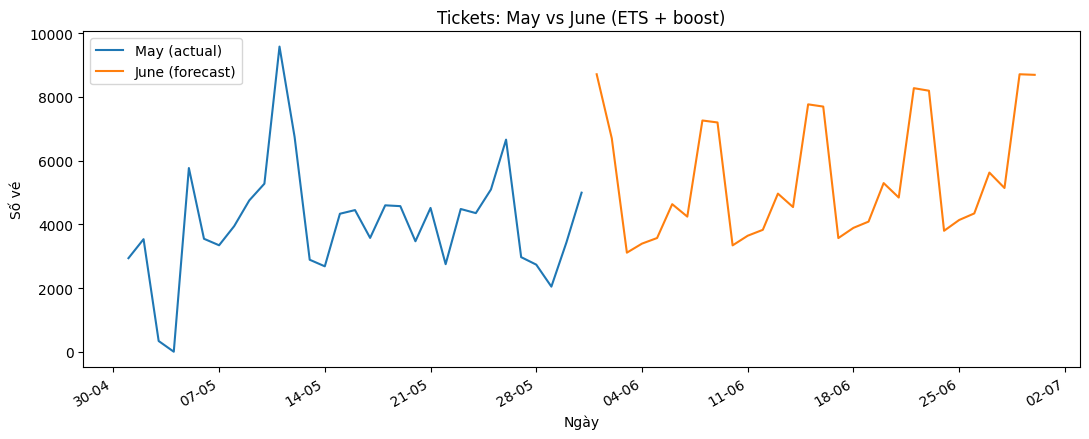

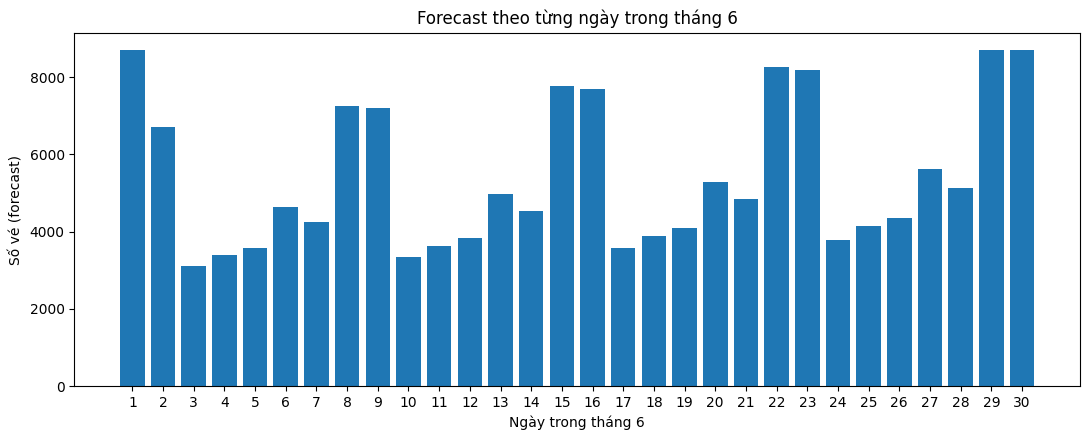

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(11,4.5))
ax.plot(month_may["date"], month_may["tickets"], label="May (actual)")
ax.plot(forecast_june["date"], forecast_june["tickets_forecast"], label="June (forecast)")
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
fig.autofmt_xdate()
ax.set_title("Tickets: May vs June (ETS + boost)")
ax.set_xlabel("Ngày"); ax.set_ylabel("Số vé"); ax.legend()
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(11,4.5))
ax.bar(forecast_june["day_of_month"], forecast_june["tickets_forecast"])
ax.set_xticks(range(1, int(forecast_june["day_of_month"].max())+1))
ax.set_xlabel("Ngày trong tháng 6"); ax.set_ylabel("Số vé (forecast)")
ax.set_title("Forecast theo từng ngày trong tháng 6")
plt.tight_layout(); plt.show()